In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Jan 26 17:08:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    65W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 50000, model_list, optimizer_list)

total 157460
-rw-rw-r-- 1 scpark scpark        0  1월 26 17:08 events.out.tfevents.1706256535.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 26 17:05 events.out.tfevents.1706239501.GPUSVR11
-rw-rw-r-- 1 scpark scpark 26604610  1월 26 17:05 events.out.tfevents.1706239582.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 16:51 save_170000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 16:35 save_160000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 16:19 save_150000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 16:04 save_140000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 15:48 save_130000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 15:33 save_120000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 15:17 save_110000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 15:02 save_100000
-rw-rw-r-- 1 scpark scpark  7478603  1월 26 14:47 save_90000
-rw-rw-r-- 1 scpark scpark  7478603  1월 26 14:31 save_80000
-rw-rw-r-- 1 scpark scpark  7478603  1월 26 14:15 save_70000
-rw-rw-r-- 1 scpark scpark  7478603  1월 26 14:00 sav

In [9]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [11]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [12]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [13]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

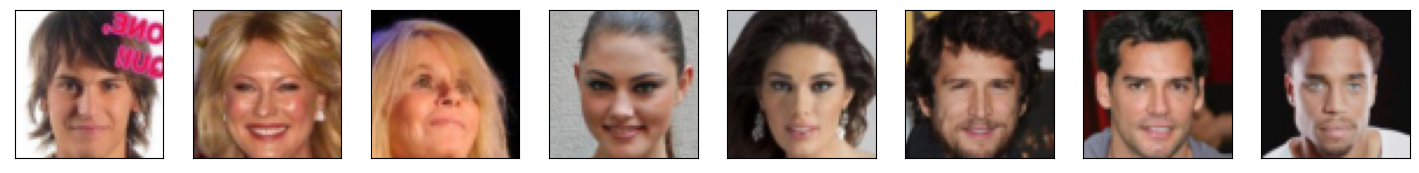

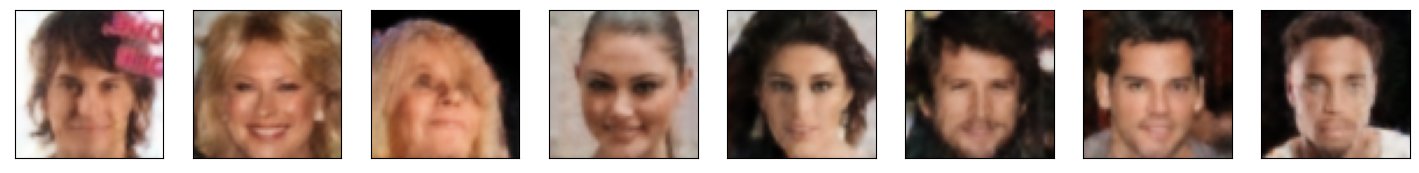

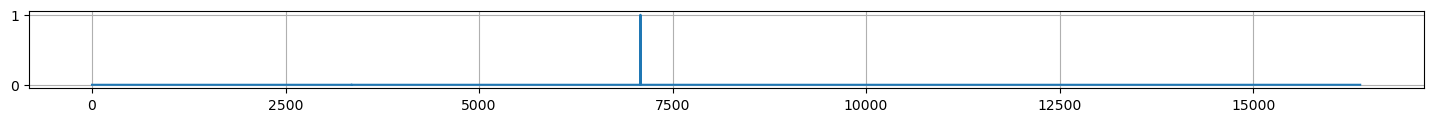

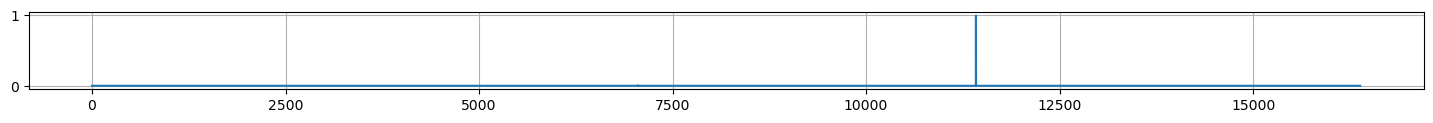

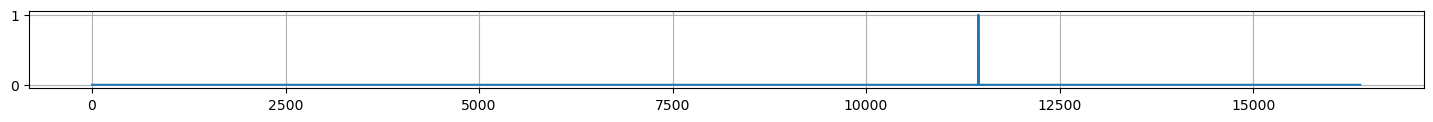

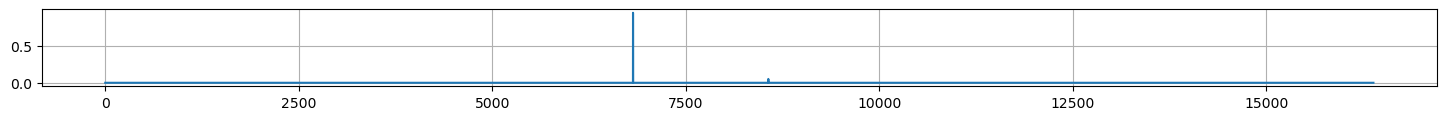

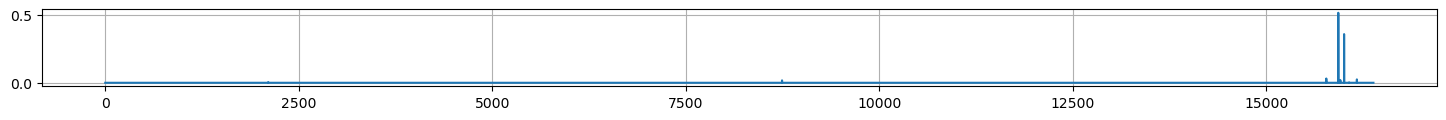

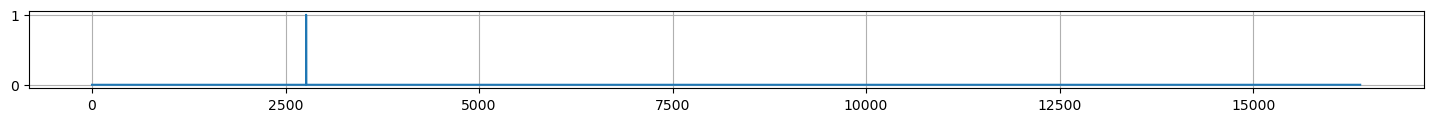

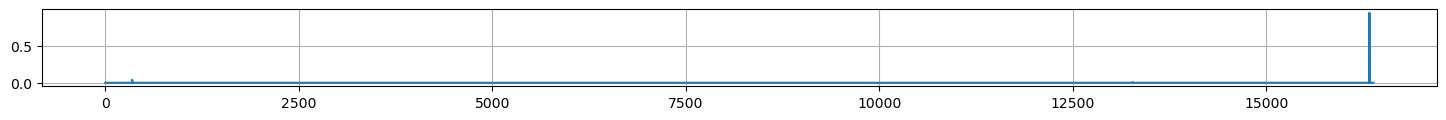

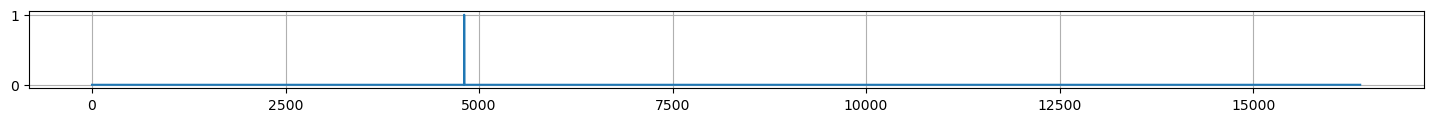

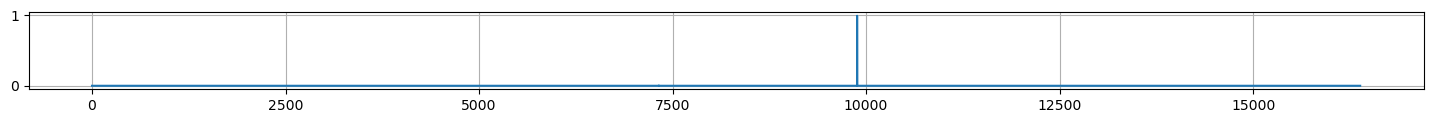

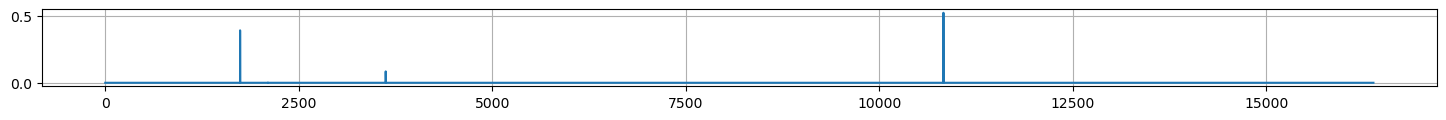

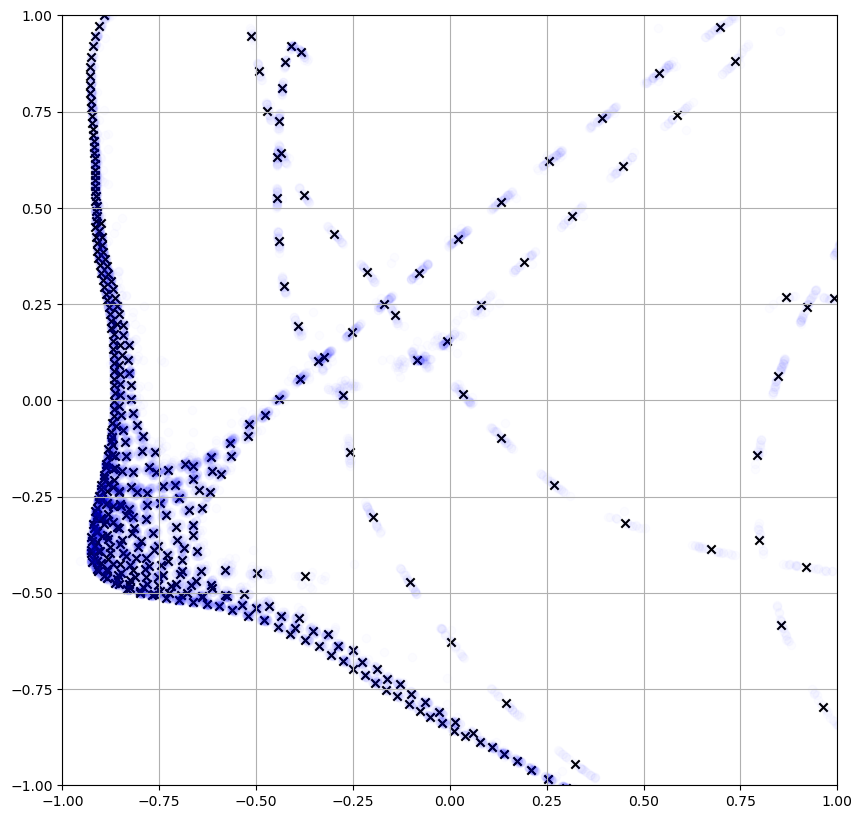

50001
lse_loss -407.2422180175781
commit_loss 7.888242544140667e-05
recon_loss 0.00258453655987978
50002
lse_loss -411.66754150390625
commit_loss 8.093879296211526e-05
recon_loss 0.0022021224722266197
50003
lse_loss -404.04034423828125
commit_loss 8.076438825810328e-05
recon_loss 0.0020127741154283285
50004
lse_loss -410.04730224609375
commit_loss 7.875428127590567e-05
recon_loss 0.0016899171750992537
50005
lse_loss -403.48590087890625
commit_loss 8.342685759998858e-05
recon_loss 0.001950833830051124
50006
lse_loss -408.4529113769531
commit_loss 7.466383249266073e-05
recon_loss 0.0016554240137338638
50007
lse_loss -408.4705505371094
commit_loss 7.68294557929039e-05
recon_loss 0.0019183288095518947
50008
lse_loss -407.51678466796875
commit_loss 8.043413981795311e-05
recon_loss 0.0018345288699492812
50009
lse_loss -409.4059753417969
commit_loss 8.085705485427752e-05
recon_loss 0.0016079600900411606
50010
lse_loss -404.3250427246094
commit_loss 7.852470298530534e-05
recon_loss 0.001659661

50084
lse_loss -404.4308776855469
commit_loss 8.251061080954969e-05
recon_loss 0.0009423637529835105
50085
lse_loss -413.5089111328125
commit_loss 7.802678737789392e-05
recon_loss 0.0010505733080208302
50086
lse_loss -403.0975341796875
commit_loss 8.182034071069211e-05
recon_loss 0.0009917570278048515
50087
lse_loss -408.8058166503906
commit_loss 8.462584810331464e-05
recon_loss 0.0010725053725764155
50088
lse_loss -409.46533203125
commit_loss 9.171605779556558e-05
recon_loss 0.0009622437646612525
50089
lse_loss -387.1708984375
commit_loss 9.062643948709592e-05
recon_loss 0.0010634384816512465
50090
lse_loss -410.8480224609375
commit_loss 8.4124636487104e-05
recon_loss 0.0010684092994779348
50091
lse_loss -411.0656433105469
commit_loss 8.227310900110751e-05
recon_loss 0.0009950174717232585
50092
lse_loss -409.001220703125
commit_loss 7.872872811276466e-05
recon_loss 0.0010153462644666433
50093
lse_loss -403.74627685546875
commit_loss 8.464952406939119e-05
recon_loss 0.00102976849302649

lse_loss -401.6112365722656
commit_loss 8.11650970717892e-05
recon_loss 0.0009083468466997147
50168
lse_loss -403.485595703125
commit_loss 8.092100324574858e-05
recon_loss 0.001026501297019422
50169
lse_loss -401.6741638183594
commit_loss 8.348138362634927e-05
recon_loss 0.0010128687135875225
50170
lse_loss -405.0562744140625
commit_loss 7.892328721936792e-05
recon_loss 0.0010732085211202502
50171
lse_loss -403.1454162597656
commit_loss 7.860972255002707e-05
recon_loss 0.001001836615614593
50172
lse_loss -406.0888977050781
commit_loss 8.762549987295642e-05
recon_loss 0.0009749502642080188
50173
lse_loss -401.9718933105469
commit_loss 8.172182424459606e-05
recon_loss 0.0010702322470024228
50174
lse_loss -401.43634033203125
commit_loss 7.855376316001639e-05
recon_loss 0.0009097445290535688
50175
lse_loss -407.8454284667969
commit_loss 8.187083585653454e-05
recon_loss 0.001049098907969892
50176
lse_loss -401.1905517578125
commit_loss 8.181666635209695e-05
recon_loss 0.001191530842334032
5

50250
lse_loss -403.7153625488281
commit_loss 9.142090857494622e-05
recon_loss 0.0009676406625658274
50251
lse_loss -408.7611999511719
commit_loss 8.403894753428176e-05
recon_loss 0.0009139023604802787
50252
lse_loss -401.50408935546875
commit_loss 8.341109787579626e-05
recon_loss 0.0009996005101129413
50253
lse_loss -403.4933166503906
commit_loss 8.158269338309765e-05
recon_loss 0.0009021254954859614
50254
lse_loss -393.2317199707031
commit_loss 8.156795229297131e-05
recon_loss 0.0008631771779619157
50255
lse_loss -405.22100830078125
commit_loss 7.629585161339492e-05
recon_loss 0.001123135327361524
50256
lse_loss -406.3987731933594
commit_loss 8.193321991711855e-05
recon_loss 0.0009091216488741338
50257
lse_loss -406.51226806640625
commit_loss 8.138762495946139e-05
recon_loss 0.0009102730546146631
50258
lse_loss -397.1311950683594
commit_loss 8.282230555778369e-05
recon_loss 0.0009354106150567532
50259
lse_loss -407.01055908203125
commit_loss 8.034126949496567e-05
recon_loss 0.0009046

lse_loss -405.25604248046875
commit_loss 7.977866334840655e-05
recon_loss 0.0009024566970765591
50333
lse_loss -400.7168884277344
commit_loss 7.717702828813344e-05
recon_loss 0.0008919105166569352
50334
lse_loss -406.32061767578125
commit_loss 8.097264071693644e-05
recon_loss 0.0009030879009515047
50335
lse_loss -397.6746520996094
commit_loss 8.55216130730696e-05
recon_loss 0.0009175993036478758
50336
lse_loss -402.1912841796875
commit_loss 8.302924106828868e-05
recon_loss 0.0007921013748273253
50337
lse_loss -390.640380859375
commit_loss 8.777237962931395e-05
recon_loss 0.000876460806466639
50338
lse_loss -406.92681884765625
commit_loss 8.150092617142946e-05
recon_loss 0.000769181118812412
50339
lse_loss -399.5970458984375
commit_loss 7.900963828433305e-05
recon_loss 0.0009167278185486794
50340
lse_loss -402.4064025878906
commit_loss 9.22197723411955e-05
recon_loss 0.0008791694417595863
50341
lse_loss -399.9708251953125
commit_loss 8.06046009529382e-05
recon_loss 0.0009239084902219474

50415
lse_loss -404.59210205078125
commit_loss 7.697995897615328e-05
recon_loss 0.0008654341800138354
50416
lse_loss -400.4816589355469
commit_loss 7.505538815166801e-05
recon_loss 0.0009764618007466197
50417
lse_loss -403.7987976074219
commit_loss 7.975246262503788e-05
recon_loss 0.0008647466893307865
50418
lse_loss -390.2618103027344
commit_loss 8.736920426599681e-05
recon_loss 0.0009188640397042036
50419
lse_loss -405.3824768066406
commit_loss 8.022206020541489e-05
recon_loss 0.0008730263798497617
50420
lse_loss -398.0193786621094
commit_loss 7.702461880398914e-05
recon_loss 0.0008698654128238559
50421
lse_loss -403.9268493652344
commit_loss 7.5828967965208e-05
recon_loss 0.0009067131904885173
50422
lse_loss -404.6658630371094
commit_loss 7.770925003569573e-05
recon_loss 0.0008363332599401474
50423
lse_loss -400.1138000488281
commit_loss 7.610266038682312e-05
recon_loss 0.0008866546559147537
50424
lse_loss -406.7778625488281
commit_loss 7.643038406968117e-05
recon_loss 0.00085112772

lse_loss -409.4239501953125
commit_loss 8.3145649114158e-05
recon_loss 0.0008764337981119752
50498
lse_loss -402.962890625
commit_loss 9.085756028071046e-05
recon_loss 0.0008231112733483315
50499
lse_loss -401.6428527832031
commit_loss 9.15651980903931e-05
recon_loss 0.0008569895289838314
50500
lse_loss -405.56158447265625
commit_loss 9.012736700242385e-05
recon_loss 0.0009121265029534698
50501
lse_loss -403.9822692871094
commit_loss 8.901455294108018e-05
recon_loss 0.0008164363680407405
50502
lse_loss -402.27178955078125
commit_loss 8.154005627147853e-05
recon_loss 0.0008204611949622631
50503
lse_loss -405.6777038574219
commit_loss 8.496521331835538e-05
recon_loss 0.0008949138573370874
50504
lse_loss -403.5019226074219
commit_loss 8.164565224433318e-05
recon_loss 0.0008281402988359332
50505
lse_loss -403.2550048828125
commit_loss 8.415261982008815e-05
recon_loss 0.000856298953294754
50506
lse_loss -404.7259216308594
commit_loss 8.268721285276115e-05
recon_loss 0.0009127798257395625
50

50580
lse_loss -406.68218994140625
commit_loss 8.32774821901694e-05
recon_loss 0.0007760062580928206
50581
lse_loss -401.44049072265625
commit_loss 9.182083158520982e-05
recon_loss 0.0008233253611251712
50582
lse_loss -408.2947692871094
commit_loss 8.568208431825042e-05
recon_loss 0.0009274682961404324
50583
lse_loss -402.2138671875
commit_loss 8.460308163193986e-05
recon_loss 0.0008754683658480644
50584
lse_loss -408.86297607421875
commit_loss 9.801700798561797e-05
recon_loss 0.0008762601646594703
50585
lse_loss -403.8865051269531
commit_loss 8.938155951909721e-05
recon_loss 0.0009509434457868338
50586
lse_loss -405.0848693847656
commit_loss 9.445365867577493e-05
recon_loss 0.0009837730322033167
50587
lse_loss -409.25042724609375
commit_loss 8.95867997314781e-05
recon_loss 0.0009056609123945236
50588
lse_loss -410.1206359863281
commit_loss 8.549884660169482e-05
recon_loss 0.0008754196460358799
50589
lse_loss -403.20166015625
commit_loss 8.771651482675225e-05
recon_loss 0.0008372936281

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 100*1000)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 